# **California Housing Analysis**
source from kaggle <br>
https://www.kaggle.com/datasets/camnugent/california-housing-prices

## 0. Set up

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv('data/housing.csv')

## 1. Data Exploration
Data type, missing values, statistical overview, distribution and etc

In [5]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


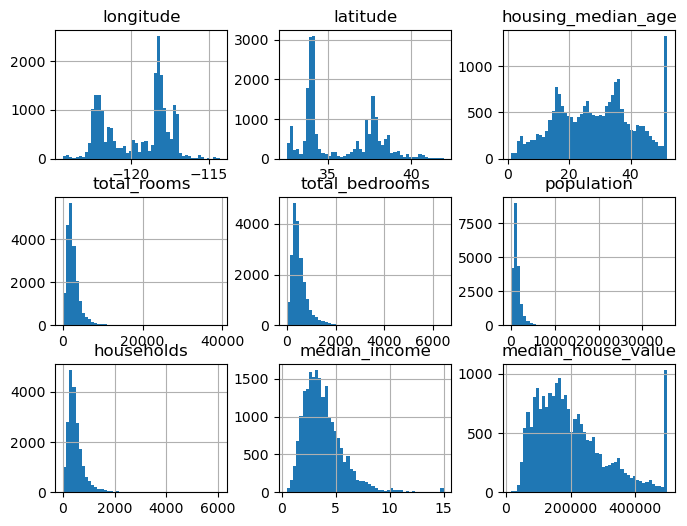

In [8]:
df.hist(bins=50,figsize=(8,6))#The bins parameter is used to custom the number of bins shown on the plots.
plt.show()

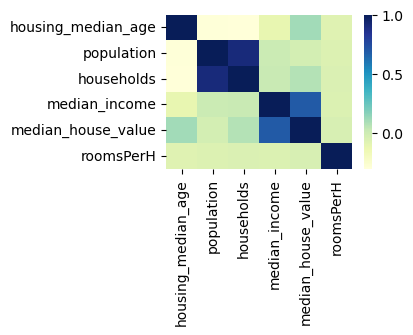

In [9]:
dfcor=df.copy()

dfcor['roomsPerH']=dfcor['total_bedrooms']/dfcor['households']
dfcor=dfcor[['housing_median_age', 'population','households','median_income','median_house_value','roomsPerH']]


import seaborn as sns
plt.figure(figsize=(3,2))
sns.heatmap(dfcor.corr(numeric_only=True), cmap='YlGnBu')
plt.show()

## 2. Location and housing value
Assuming that housing prices in coastal areas may be higher, <br>
it is worth exploring this hypothesis further by analyzing key metrics.

In [10]:
df.groupby('ocean_proximity').agg(Income=('median_income', 'mean'),
                                    House_value=('median_house_value', 'mean'),
                                    Count=('median_house_value', 'count'))


,Income,House_value,Count
ocean_proximity,,,
<1H OCEAN,4.230682,240084.285464,9136
INLAND,3.208996,124805.392001,6551
ISLAND,2.744420,380440.000000,5
NEAR BAY,4.172885,259212.311790,2290
NEAR OCEAN,4.005785,249433.977427,2658


Simplify the 'ocean_proximity' column into two categories: Coastal and Inland. <br>
Exclude 'island' since it has only 5 entries.

In [11]:
# Define the mapping dictionary
mapping_dict = {
    'NEAR BAY': 'Coastal',
    'NEAR OCEAN': 'Coastal',
    '<1H OCEAN': 'Coastal',
    'INLAND': 'Inland',
    'ISLAND': 'Island'}

LocationHouseValue = df[['ocean_proximity','median_income','median_house_value']]
LocationHouseValue['Location'] = LocationHouseValue['ocean_proximity'].map(mapping_dict)
LocationHouseValue = LocationHouseValue[LocationHouseValue['Location'] != 'Island']

LocationHouseValue.groupby('Location')[['median_income','median_house_value']].mean()

/var/folders/82/038lb7sx7w981ctcvb0s2px00000gn/T/ipykernel_909/822623711.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LocationHouseValue['Location'] = LocationHouseValue['ocean_proximity'].map(mapping_dict)


,median_income,median_house_value
Location,,
Coastal,4.178841,244958.941920
Inland,3.208996,124805.392001


Making the most of geographical information (longitude and latitude),<br>
create a scatterplot that resembles a real map. <br>
Use different colors to represent locations and adjust marker sizes based on housing values.

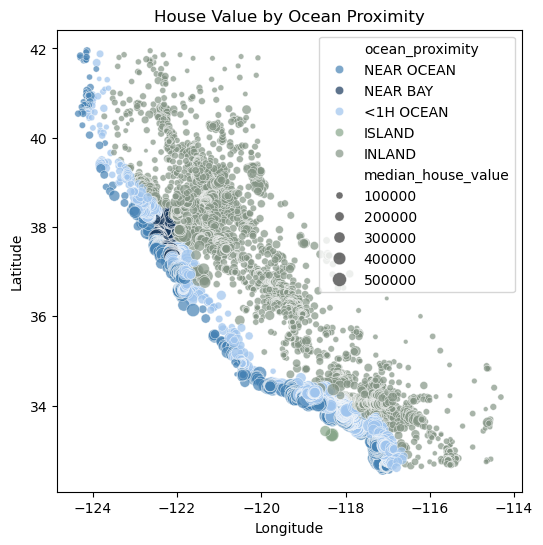

In [12]:
plt.figure(figsize=(6, 6))

color_mapping = {
    "NEAR OCEAN": "#4682B4",
    "NEAR BAY": "#18385c",  
    "<1H OCEAN": "#9fc4ed", 
    "ISLAND": "#88a68a" ,
    "INLAND": "#849485"}

sns.scatterplot(
    data=df, x="longitude", y="latitude", size="median_house_value", 
    sizes=(10, 100), 
    hue="ocean_proximity", palette=color_mapping, hue_order= ["NEAR OCEAN","NEAR BAY", "<1H OCEAN","ISLAND","INLAND"],
    alpha=0.7)

plt.title("House Value by Ocean Proximity")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Create a bar plot to directly compare the housing values of Coastal and Inland areas.

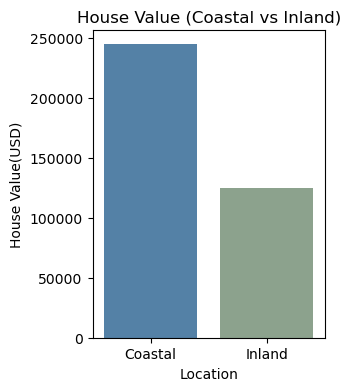

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 4))
sns.barplot(data=LocationHouseValue.groupby('Location')[['median_income','median_house_value']].mean(), 
            x='Location', y='median_house_value',
            hue='Location', palette=["#4682B4","#88a68a"] )
plt.title('House Value (Coastal vs Inland)')
plt.ylabel('House Value(USD)')
plt.show()


## 3. Income and House value

The correlation heatmap indicates the strongest correlation between median_income and median_house_value. <br>
A scatterplot could help clarify this relationship. <br>
However, data cleaning (removing outliers) may be necessary beforehand.

In [16]:
df['median_house_value'].corr(df['median_income'])

0.6880752079585484

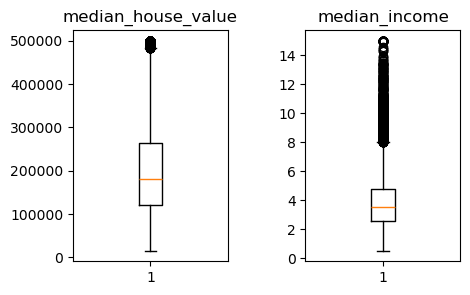

In [17]:
plt.figure(figsize=(5, 3))

# First plot (median_income)
plt.subplot(1, 2, 1)  # (rows, columns, position)
plt.boxplot(df['median_house_value'])
plt.title('median_house_value')

# Second plot (median_house_value)
plt.subplot(1, 2, 2)
plt.boxplot(df['median_income'])
plt.title('median_income')

plt.subplots_adjust(wspace=0.5)

plt.show()


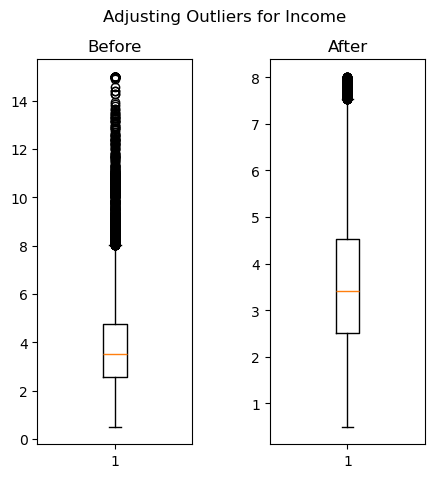

In [19]:
# Calculate Q1, Q3, and IQR
valueQ1 = df['median_house_value'].quantile(0.25)
valueQ3 = df['median_house_value'].quantile(0.75)
valueIQR = valueQ3 - valueQ1
value_upper = valueQ3 + 1.5 * valueIQR

incomeQ1 = df['median_income'].quantile(0.25)
incomeQ3 = df['median_income'].quantile(0.75)
incomeIQR = incomeQ3 - incomeQ1
income_upper = incomeQ3 + 1.5 * incomeIQR

Income_HouseValue = df[(df['median_house_value']<value_upper) & (df['median_income']<income_upper)][['median_house_value','median_income']]


plt.figure(figsize=(5, 5))

# First plot (median_income)
plt.subplot(1, 2, 1) 
plt.boxplot(df['median_income'])
plt.title('Before')

# Second plot (median_house_value)
plt.subplot(1, 2, 2)
plt.boxplot(Income_HouseValue['median_income'])
plt.title('After')

plt.suptitle('Adjusting Outliers for Income')
plt.subplots_adjust(wspace=0.5)

plt.show()


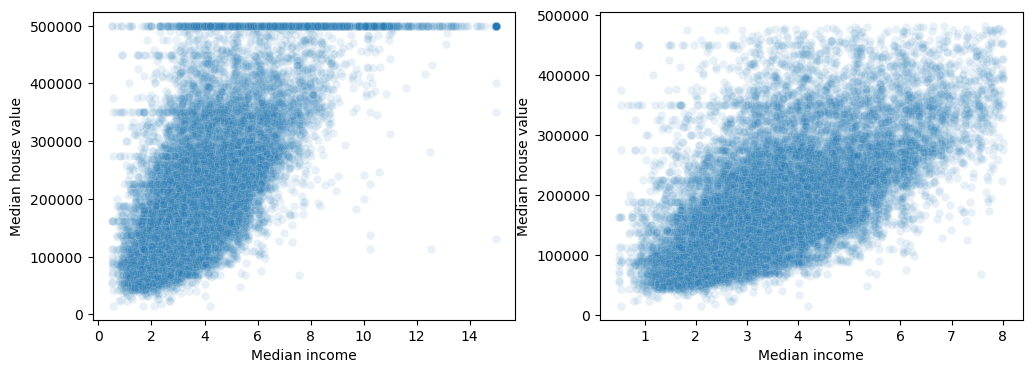

In [20]:
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
sns.scatterplot(x='median_income',y='median_house_value', data=df,alpha=0.1)
plt.xlabel('Median income')
plt.ylabel('Median house value')

plt.subplot(1,2,2)
sns.scatterplot(x='median_income',y='median_house_value', data=Income_HouseValue, alpha=0.1)
plt.xlabel('Median income')
plt.ylabel('Median house value')
plt.show()

In [22]:
dfa=df[['median_income', 'median_house_value']]
dfb=dfa[(dfa['median_house_value']<dfa['median_house_value'].quantile(0.90)) &
        (dfa['median_income']<dfa['median_income'].quantile(0.90))]


**Try a hexbin plot to visualize the density, <br>
and check if the dots are concentrated in a way that clarifies the trend.**

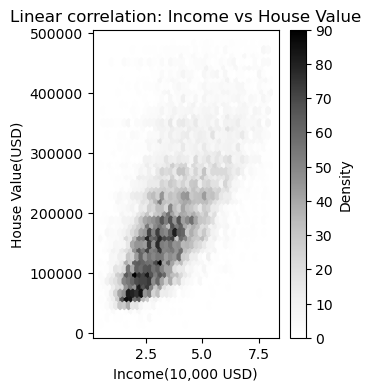

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 4))

# Hexbin plot
plt.hexbin(Income_HouseValue['median_income'], Income_HouseValue['median_house_value'], gridsize=40, cmap='Greys')

plt.colorbar(label='Density')

plt.xlabel('Income(10,000 USD)')
plt.ylabel('House Value(USD)')
plt.title('Linear correlation: Income vs House Value')

plt.show()


## 4. Prediction Model
Try two different methods: simple linear regression and random forest regressor.

In [24]:
clean_df=df.copy()

### 4.1. Fill in missing value
Before getting into modeling, data preprocessing is necessary <br>
Fill missing values in the 'total_bedrooms' column.

In [7]:
clean_df['total_bedrooms'] = clean_df['total_bedrooms'].fillna(clean_df['total_bedrooms'].mean())

However, since 'total_bedrooms' and 'total_rooms' provide similar information, only one of them is needed.

The values in the 'total_rooms' column represent the total number of rooms within the block. <br>
-> A new column has been created by dividing the total number of rooms by the number of households.


In [8]:
clean_df['roomsPh']=clean_df['total_rooms']/clean_df['households']
clean_df=clean_df.drop(columns=['total_rooms','total_bedrooms'])
clean_df.head()

,longitude,latitude,housing_median_age,population,households,median_income,median_house_value,ocean_proximity,roomsPh
0,-122.23,37.88,41.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.984127
1,-122.22,37.86,21.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.238137
2,-122.24,37.85,52.0,496.0,177.0,7.2574,352100.0,NEAR BAY,8.288136
3,-122.25,37.85,52.0,558.0,219.0,5.6431,341300.0,NEAR BAY,5.817352
4,-122.25,37.85,52.0,565.0,259.0,3.8462,342200.0,NEAR BAY,6.281853


### 4.2. OneHotEncoding for Ocean_proximity
OneHotEncoding to 'ocean_proximity' (categorical -> numerical)


In [9]:
clean_df = pd.get_dummies(clean_df, columns=['ocean_proximity'], prefix=['ocean_prox'], drop_first=True)

In [10]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   longitude              20640 non-null  float64
 1   latitude               20640 non-null  float64
 2   housing_median_age     20640 non-null  float64
 3   population             20640 non-null  float64
 4   households             20640 non-null  float64
 5   median_income          20640 non-null  float64
 6   median_house_value     20640 non-null  float64
 7   roomsPh                20640 non-null  float64
 8   ocean_prox_INLAND      20640 non-null  bool   
 9   ocean_prox_ISLAND      20640 non-null  bool   
 10  ocean_prox_NEAR BAY    20640 non-null  bool   
 11  ocean_prox_NEAR OCEAN  20640 non-null  bool   
dtypes: bool(4), float64(8)
memory usage: 1.3 MB


### 4.3. Split dataset (test&train)
Using the cleaned dataset, split it into training and testing sets with a 4:1 ratio.

In [11]:
X = clean_df.drop(columns=['median_house_value'])
y = clean_df['median_house_value']

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4.4 Model: Linear Regression
 - r2score: 0.63
 - RMSE: 69,557($)

In [155]:
from sklearn.linear_model import LinearRegression
mlr=LinearRegression()
mlr.fit(X_train,y_train)

LinearRegression()

In [156]:
mlr.score(X_test, y_test)

0.6307869137174342

In [157]:
from sklearn.metrics import mean_squared_error
import numpy as np
y_pred=mlr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 69557.18102027326


### 4.5 Model: RandomForestRegressor
 - r2score: 0.81
 - RMSE: 48,347($)


In [13]:
from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor()
rfr.fit(X_train,y_train)

RandomForestRegressor()

In [159]:
rfr.score(X_test, y_test)

0.8192260015972397

In [14]:
y_pred=rfr.predict(X_test)
mse1 = mean_squared_error(y_test, y_pred)
rmse1 = np.sqrt(mse1)
print("RMSE:", rmse1)

RMSE: 48347.02134693058


### 4.6. Sampling Test with RandomForestRegressor

It's turned out that the RandomForest model performs relatively better. <br>
Using the model, repeat five samplings from the cleaned dataset (before splitting into training and test sets). <br>
If the predicted value of the fitted model falls within ±10% of the true value, it passes; otherwise, it fails.

In [49]:
test_result=[]

for i in range(0,5):
    sample=clean_df.sample(frac=0.2)
    sampleX = sample.drop(columns=['median_house_value'])
    sampley = sample['median_house_value']
    samplePred=rfr.predict(sampleX)
    
    test=pd.DataFrame(data={'true':sampley, 'prediction':samplePred})
    test['Result'] = test.apply(lambda x: 'Pass' if x['true'] * 0.9 <= x['prediction'] <= x['true'] * 1.1 else 'Fail', axis=1)
    test_result.append(test.groupby('Result')['prediction'].count().values)

result_df = pd.DataFrame(data=test_result,
                         index=['Test1','Test2','Test3','Test4','Test5'],
                         columns=['Fail','Pass']
                        )
result_df['Pass_%']= result_df['Pass'] / (result_df['Pass']+ result_df['Fail'] ) * 100
result_df['Pass_%']= result_df['Pass_%'].round(2)


result_df

,Fail,Pass,Pass_%
Test1,1009,3119,75.56
Test2,1024,3104,75.19
Test3,1061,3067,74.30
Test4,1051,3077,74.54
Test5,1069,3059,74.10
